## Lab 5: Linear and Logistic Regression

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Linear Regression with Regularization

In this lab, we will revisit our earlier linear regression solution, transform it to look more like the `LinearRegression` object from the `sklearn` package, and then repurpose it to solve both linear regression with regularization (LASSO and Ridge regression) and classification via Logistic Regression.

*First, we will load the dataset.*

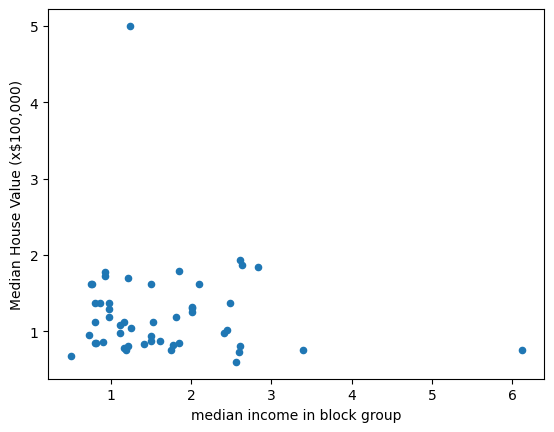

In [50]:
from sklearn.datasets import fetch_california_housing
hd = fetch_california_housing()
housing = pd.DataFrame(hd.data, columns=hd.feature_names)
housing['target'] = hd.target
housing.iloc[50:100,:].plot.scatter(x='MedInc', y='target')
plt.xlabel('median income in block group')
plt.ylabel('Median House Value (x$100,000)')
plt.show()
# housing

In [4]:
print(hd.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [5]:
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Next, we will find the best model via Gradient Descent.

In [51]:
class LinearRegressionGD:
    def __init__(self, fit_intercept=True, nulbias=False, learning_rate=0.5, max_iter=1e+6, tol=1e-5):
        if learning_rate <= 0:
            raise ValueError("Learning rate must be positive.")
        if max_iter <= 0:
            raise ValueError("max_iter must be positive.")
        if tol <= 0:
            raise ValueError("tol must be positive.")
        self.fit_intercept = fit_intercept
        self.learning_rate = learning_rate
        self.nulbias = nulbias
        self.max_iter = int(max_iter)
        self.tol = tol
        self.models = []
        self.costs = []
        self.gradients = [] 
        self.coef_ = None
        self.intercept_ = None

    def _add_intercept(self, X):
        return np.hstack([np.ones((X.shape[0], 1)), X])

    def fit(self, X, y):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        y = np.asarray(y).reshape(-1, 1)

        if self.fit_intercept:
            X = self._add_intercept(X)

        n_samples, n_features = X.shape
        theta = np.random.randn(n_features, 1)
        if self.nulbias:
            theta[0] = 0
        # Perform gradient descent
        for _ in range(self.max_iter):
            # Hypothesis/estimate values for y
            y_estimate = (X @ theta).flatten()
            # Loss - the difference between the estimated and actual values of y
            loss = y_estimate - y.flatten()
            # Compute gradient
            grad = ((1.0 / n_samples) * X.T.dot(loss))
            # Cost function value
            cost = float(0.5 * np.mean((y_estimate - y.flatten())**2))
            # Keep track of the model, gradient, and cost
            self.models.append(theta)
            self.gradients.append(grad)
            self.costs.append(cost)
            # Update theta
            grad = grad.reshape(theta.shape)
            theta_new = theta - self.learning_rate * grad
            if self.nulbias:
                theta_new[0] = 0
            # Check for convergence
            if np.sum(abs(theta_new - theta)) < self.tol:
                break
            theta = theta_new

        # we can now set the intercept and coef_ attributes
        if self.fit_intercept:
            self.intercept_ = theta[0, 0]
            self.coef_ = np.ravel(theta[1:, 0])
        else:
            self.intercept_ = 0.0
            self.coef_ = np.ravel(theta[:, 0])

    def compute_cost(self, X, y):
        """Compute the current error/cost."""
        # Hypothesis/estimate values for y
        y_estimate = self.predict(X)
        # Cost function value
        return float(0.5 * np.mean((y_estimate - y.flatten())**2))

    def predict(self, X):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        if self.fit_intercept:
            X = self._add_intercept(X)
            beta = np.concatenate([[self.intercept_], self.coef_])
        else:
            beta = self.coef_
        return (X @ beta).flatten()

To make things easier to visualize, we're only going to pick 50 samples and the frist two features from the dataset. Also, to ensure proper model training, we will normalize the features (not including the target) using L-inf (max) normalization.

In [52]:
# extract 100 rows
data = housing.loc[51:100].to_numpy()
# split into features and target
# We'll consider just the first two features; the target is the last column
X = data[:, 0:2]
y = data[:, -1]
# normalize the data except for the target
X = X / X.max(axis=0)

model_gd = LinearRegressionGD(nulbias=True)
model_gd.fit(X, y)
print("Intercept: ", model_gd.intercept_)
print("Coefficient: ", model_gd.coef_)
print("Cost: ", model_gd.costs[-1])
print("# iterations: ", len(model_gd.models))

Intercept:  0.0
Coefficient:  [1.4284422  0.96363773]
Cost:  0.3317593960741997
# iterations:  553


We can plot the cost function in terms of the $\theta$ value. Note that, since we have chosen 2 features, even if we set a null bias, we will have to construct a 3D graph showing $\theta_0$, associated with the first feature, and $\theta_1$, associated with the second. Remember that our prediciton value is the linear combination of the input sample with $\theta$.

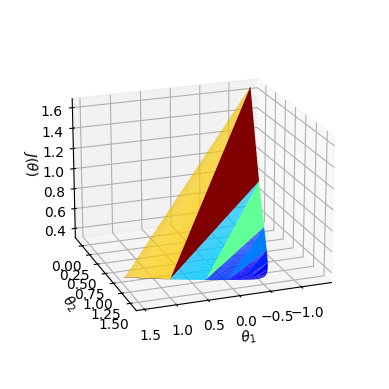

In [53]:
from matplotlib import cm
# plot the cost function as a 3D surface, ignoring the bios, which is set to 0
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
mx = np.array([m[1] for m in model_gd.models]).flatten()
my = np.array([m[2] for m in model_gd.models]).flatten()
ax.plot_trisurf(mx, my, model_gd.costs, cmap=cm.jet, linewidth=0.2)
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_zlabel(r'$J(\theta)$')

# rotate the plot to see the cost function surface better
ax.view_init(elev=20, azim=70)
# fit labels in plot
ax.set_box_aspect(None, zoom=0.85)
plt.show()


# Exercise 1: LassoRegressionGD

Modify the LinearRegressionGD to create LassoRegressionGD by adding an `L1(theta)` regression term in the cost function. To create a LassoRegressionGD (i.e., L1-regularized gradient descent), we need to modify two parts:

- The Cost Function: Add `lambda * sum(abs(theta))` to the cost.

- The Gradient: Add a subgradient for L1, which is `lambda * sign(theta)` (elementwise sign).

Also, we do not want to penalize the bias term (intercept), only the feature weights.

In [54]:
class LassoRegressionGD:
    def __init__(self, fit_intercept=True, nulbias=False, learning_rate=0.5, max_iter=1e+6, tol=1e-5, l1_penalty=0.1):
        if learning_rate <= 0:
            raise ValueError("Learning rate must be positive.")
        if max_iter <= 0:
            raise ValueError("max_iter must be positive.")
        if tol <= 0:
            raise ValueError("tol must be positive.")
        self.fit_intercept = fit_intercept
        self.learning_rate = learning_rate
        self.nulbias = nulbias
        self.max_iter = int(max_iter)
        self.tol = tol
        self.models = []
        self.costs = []
        self.gradients = [] 
        self.coef_ = None
        self.intercept_ = None
        self.l1_penalty = l1_penalty

    def _add_intercept(self, X):
        return np.hstack([np.ones((X.shape[0], 1)), X])

    def fit(self, X, y):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        y = np.asarray(y).reshape(-1, 1)

        if self.fit_intercept:
            X = self._add_intercept(X)

        n_samples, n_features = X.shape
        theta = np.random.randn(n_features, 1)
        if self.nulbias:
            theta[0] = 0
        # Perform gradient descent
        for _ in range(self.max_iter):
            # Hypothesis/estimate values for y
            y_estimate = (X @ theta).flatten()
            # Loss - the difference between the estimated and actual values of y
            loss = y_estimate - y.flatten()
            # Compute gradient
            grad = ((1.0 / n_samples) * X.T.dot(loss))
            l1_grad = self.l1_penalty * np.sign(theta)
            if self.fit_intercept:
                l1_grad[0] = 0
            total_grad = grad.reshape(theta.shape) + l1_grad
            # Cost function value
            cost = float(0.5 * np.mean((y_estimate - y.flatten())**2)) + self.l1_penalty * np.sum(np.abs(theta[1:] if self.fit_intercept else theta))
            # Keep track of the model, gradient, and cost
            self.models.append(theta)
            self.gradients.append(total_grad)
            self.costs.append(cost)
            # Update theta
            theta_new = theta - self.learning_rate * total_grad
            if self.nulbias:
                theta_new[0] = 0
            # Check for convergence
            if np.sum(abs(theta_new - theta)) < self.tol:
                break
            theta = theta_new

        # we can now set the intercept and coef_ attributes
        if self.fit_intercept:
            self.intercept_ = theta[0, 0]
            self.coef_ = np.ravel(theta[1:, 0])
        else:
            self.intercept_ = 0.0
            self.coef_ = np.ravel(theta[:, 0])

    def compute_cost(self, X, y):
        """Compute the current error/cost."""
        # Hypothesis/estimate values for y
        y_estimate = self.predict(X)
        # Cost function value
        return float(0.5 * np.mean((y_estimate - y.flatten())**2))  + elf.l1_penalty * np.sum(np.abs(self.coef_[1:] if self.fit_intercept else self_coef))

    def predict(self, X):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        if self.fit_intercept:
            X = self._add_intercept(X)
            beta = np.concatenate([[self.intercept_], self.coef_])
        else:
            beta = self.coef_
        return (X @ beta).flatten()


If you remember from the lecture, Lasso simplifies the model by forcing some of its components to become 0. In the example below, we will simulate a dataset where only a few features matter and see how the Lasso and Linear Regression models compare in model complexity.

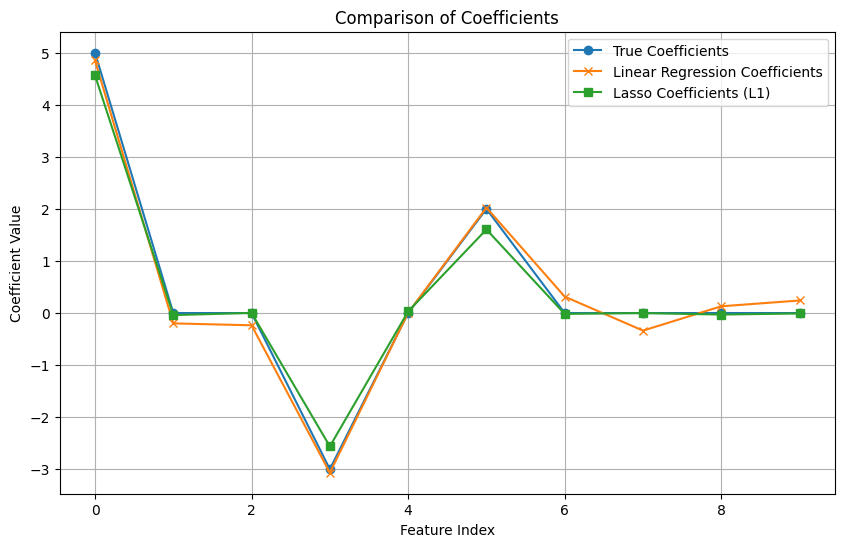

Number of features pruned by Lasso:  7
Number of features pruned by Linear Regression:  1


In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(99)

# Create synthetic data
n_samples, n_features = 50, 10
X = np.random.randn(n_samples, n_features)

# True coefficients: only 3 nonzero!
true_coef = np.array([5.0, 0.0, 0.0, -3.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0])
y = X @ true_coef + np.random.randn(n_samples) * 1.5  # add noise

# --- Fit Normal Linear Regression ---
linear_model = LinearRegressionGD(fit_intercept=True, learning_rate=0.1, max_iter=10000, tol=1e-6)
# this should be equivalent to Lasso with l1_penalty=0.0
# linear_model = LassoRegressionGD(fit_intercept=True, l1_penalty=0.0, learning_rate=0.1, max_iter=10000, tol=1e-6)
linear_model.fit(X, y)

# --- Fit Lasso Regression ---
lasso_model = LassoRegressionGD(fit_intercept=True, l1_penalty=0.5, learning_rate=0.1, max_iter=10000, tol=1e-6)
lasso_model.fit(X, y)

# --- Plot coefficients ---
plt.figure(figsize=(10,6))
plt.plot(true_coef, 'o-', label='True Coefficients')
plt.plot(linear_model.coef_, 'x-', label='Linear Regression Coefficients')
plt.plot(lasso_model.coef_, 's-', label='Lasso Coefficients (L1)')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Comparison of Coefficients')
plt.legend()
plt.grid(True)
plt.show()

# Check how many features were pruned by the two models
print("Number of features pruned by Lasso: ", np.sum(np.abs(lasso_model.coef_) <= 1e-1))
print("Number of features pruned by Linear Regression: ", np.sum(np.abs(linear_model.coef_) <= 1e-1))


Note that the Lasso model is able to set the irrelevant features of the model to 0, whereas the original linear regression model learns sligntly non-zero values.

## Exercise 2: Ridge Regression

Repeat the exercise above to create `RidgeRegressionCG`, a linear regression model with an `L2(theta)` penalty added to the cost function.  The cost function for Ridge Regression is given by,

$\text{cost} = \frac{1}{2n}\sum_i^n(y_i - x_i^T\theta)^2 + \frac{\lambda}{2}\left\Vert\theta\right\Vert^2$.

Just like you did in the case of Lasso, you will need to update both your cost calculation and your gradient update. Remember that the L2 penalty should only be applied to the coefficients, not to the intercept term.

In [56]:
class RidgeRegressionGD:
    def __init__(self, fit_intercept=True, nulbias=False, l2_penalty=1.0, learning_rate=0.1, max_iter=1e6, tol=1e-5):
        if learning_rate <= 0:
            raise ValueError("Learning rate must be positive.")
        if max_iter <= 0:
            raise ValueError("max_iter must be positive.")
        if tol <= 0:
            raise ValueError("tol must be positive.")
        self.fit_intercept = fit_intercept
        self.learning_rate = learning_rate
        self.nulbias = nulbias
        self.max_iter = int(max_iter)
        self.tol = tol
        self.models = []
        self.costs = []
        self.gradients = []
        self.coef_ = None
        self.intercept_ = None
        self.l2_penalty = l2_penalty

    def _add_intercept(self, X):
        return np.hstack([np.ones((X.shape[0], 1)), X])

    def fit(self, X, y):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        y = np.asarray(y).reshape(-1, 1)

        if self.fit_intercept:
            X = self._add_intercept(X)

        n_samples, n_features = X.shape
        theta = np.random.randn(n_features, 1)
        if self.nulbias:
            theta[0] = 0
        # Perform gradient descent
        for _ in range(self.max_iter):
            # Hypothesis/estimate values for y
            y_estimate = (X @ theta).flatten()
            # Loss - the difference between the estimated and actual values of y
            loss = y_estimate - y.flatten()
            # Compute gradient
            grad = ((1.0 / n_samples) * X.T.dot(loss))
            l2_grad = self.l2_penalty * theta
            if self.fit_intercept:
                l2_grad[0] = 0
            # Cost function value
            cost = float(0.5 * np.mean((y_estimate - y.flatten())**2)) + 0.5 * self.l2_penalty * np.sum(theta[1:]**2 if self.fit_intercept else theta**2)
            total_grad = grad.reshape(theta.shape) + l2_grad
            # Keep track of the model, gradient, and cost
            self.models.append(theta)
            self.gradients.append(total_grad)
            self.costs.append(cost)
            # Update theta
            theta_new = theta - self.learning_rate * total_grad
            if self.nulbias:
                theta_new[0] = 0
            # Check for convergence
            if np.sum(abs(theta_new - theta)) < self.tol:
                break
            theta = theta_new

         # we can now set the intercept and coef_ attributes
        if self.fit_intercept:
            self.intercept_ = theta[0, 0]
            self.coef_ = np.ravel(theta[1:, 0])
        else:
            self.intercept_ = 0.0
            self.coef_ = np.ravel(theta[:, 0])

    def compute_cost(self, X, y):
        """Compute the current error/cost."""
        # Hypothesis/estimate values for y
        y_estimate = self.predict(X)
        # Cost function value
        return float(0.5 * np.mean((y_estimate - y.flatten())**2)) + 0.5 * self.l2_penalty * np.sum(theta[1:]**2 if self.fit_intercept else theta**2)

    def predict(self, X):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        if self.fit_intercept:
            X = self._add_intercept(X)
            beta = np.concatenate([[self.intercept_], self.coef_])
        else:
            beta = self.coef_
        return (X @ beta).flatten()
        

Ridge shrinks weights but does not drive them to exactly zero (unlike Lasso). In this example, we will compare the Linear, Lasso, and Ridge regression solutions for the earlier problem.

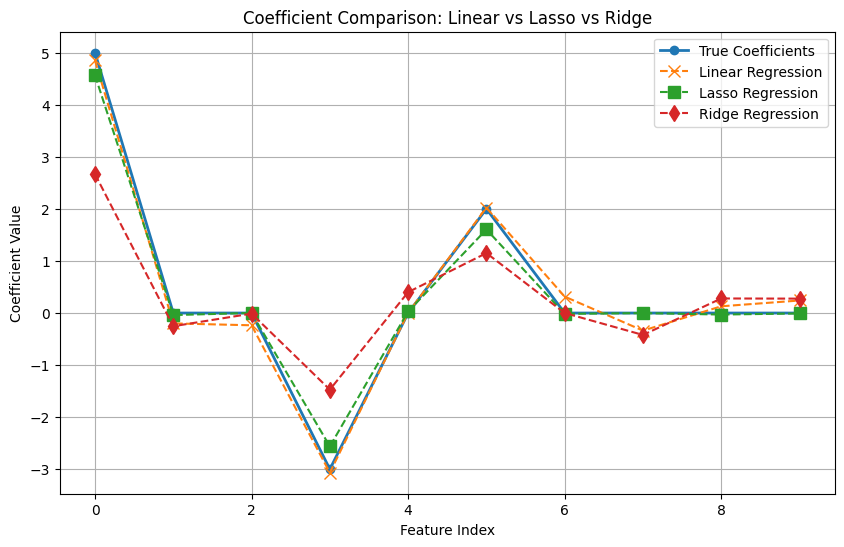

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(99)

# Create synthetic data
n_samples, n_features = 50, 10
X = np.random.randn(n_samples, n_features)

# True coefficients: only 3 nonzero!
true_coef = np.array([5.0, 0.0, 0.0, -3.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0])
y = X @ true_coef + np.random.randn(n_samples) * 1.5  # add noise

# --- Linear Regression (no penalty) ---
linear_model = LinearRegressionGD(fit_intercept=True, learning_rate=0.1, max_iter=10000, tol=1e-6)
linear_model.fit(X, y)

# --- Lasso Regression (L1 penalty) ---
lasso_model = LassoRegressionGD(fit_intercept=True, l1_penalty=0.5, learning_rate=0.1, max_iter=10000, tol=1e-6)
lasso_model.fit(X, y)

# --- Ridge Regression (L2 penalty) ---
ridge_model = RidgeRegressionGD(fit_intercept=True, l2_penalty=1.0, learning_rate=0.1, tol=1e-6, max_iter=1000)
ridge_model.fit(X, y)

# --- Plot Coefficient Comparison ---
plt.figure(figsize=(10,6))
plt.plot(true_coef, 'o-', label='True Coefficients', linewidth=2)
plt.plot(linear_model.coef_, 'x--', label='Linear Regression', markersize=8)
plt.plot(lasso_model.coef_, 's--', label='Lasso Regression', markersize=8)
plt.plot(ridge_model.coef_, 'd--', label='Ridge Regression', markersize=8)
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Coefficient Comparison: Linear vs Lasso vs Ridge')
plt.legend()
plt.grid(True)
plt.show()


## Exercise 3: Logistic Regression

Modify the `LinearRegressionGD` object to create `LogisticRegressionGD`. The new object should perform classification via logistic regression. If you remmeber from class, here are the main differences between Linear Regression and Logistic Regression.

| | **Linear Regression** | **Logistic Regression** |
| --- | --- | --- |
| *Loss*: | MSE | Binary Cross Entropy (Log Loss)
| *Activation*: |  None | sigmoid function | 
| *Prediction*: | $\hat{y} = X\theta$ | $\hat{y} = \sigma(X\theta$) |
| *Output*: | real-valued $y$ | $p(y=1)$ |

*Note*: You may want to add a small value like `1e-15` to any values you compute logs of to prevent numeric instability ($\log(0)$).

In [58]:
import numpy as np

class LogisticRegressionGD:
    def __init__(self, fit_intercept=True, nulbias=False, learning_rate=0.5, max_iter=1e6, tol=1e-5):
        if learning_rate <= 0:
            raise ValueError("Learning rate must be positive.")
        if max_iter <= 0:
            raise ValueError("max_iter must be positive.")
        if tol <= 0:
            raise ValueError("tol must be positive.")
        self.fit_intercept = fit_intercept
        self.learning_rate = learning_rate
        self.nulbias = nulbias
        self.max_iter = int(max_iter)
        self.tol = tol
        self.models = []
        self.costs = []
        self.gradients = [] 
        self.coef_ = None
        self.intercept_ = None

    def _add_intercept(self, X):
        return np.hstack([np.ones((X.shape[0], 1)), X])

    def fit(self, X, y):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        y = np.asarray(y).reshape(-1, 1)

        if self.fit_intercept:
            X = self._add_intercept(X)

        n_samples, n_features = X.shape
        theta = np.random.randn(n_features, 1)
        if self.nulbias:
            theta[0] = 0
        # Perform gradient descent
        for _ in range(self.max_iter):
            # Hypothesis/estimate values for y
            y_estimate = 1/(1 + np.exp(-(X @ theta)))
            # Loss - the difference between the estimated and actual values of y
            loss = y_estimate - y
            # Compute gradient
            grad = ((1.0 / n_samples) * X.T.dot(loss))
            # Cost function value
            eps = 1e-15
            y_estimate_clipped = np.clip(y_estimate, eps, 1 - eps)
            cost = -np.mean(y * np.log(y_estimate_clipped) + (1 - y) * np.log(1 - y_estimate_clipped))
            # Keep track of the model, gradient, and cost
            self.models.append(theta)
            self.gradients.append(grad)
            self.costs.append(cost)
            # Update theta
            grad = grad.reshape(theta.shape)
            theta_new = theta - self.learning_rate * grad
            if self.nulbias:
                theta_new[0] = 0
            # Check for convergence
            if np.sum(abs(theta_new - theta)) < self.tol:
                break
            theta = theta_new

        # we can now set the intercept and coef_ attributes
        if self.fit_intercept:
            self.intercept_ = theta[0, 0]
            self.coef_ = np.ravel(theta[1:, 0])
        else:
            self.intercept_ = 0.0
            self.coef_ = np.ravel(theta[:, 0])

    def compute_cost(self, X, y):
        """Compute the current error/cost."""
        y_estimate = self.predict_proba(X).reshape(-1, 1)
        eps = 1e-15
        y_estimate_clipped = np.clip(y_estimate, eps, 1 - eps)
        y = y.reshape(-1, 1)
        return float(-np.mean(y * np.log(y_estimate_clipped) + (1 - y) * np.log(1 - y_estimate_clipped)))

    def predict_proba(self, X):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        if self.fit_intercept:
            X = self._add_intercept(X)
            beta = np.concatenate([[self.intercept_], self.coef_])
        else:
            beta = self.coef_
        return (X @ beta).flatten()

    def predict(self, X, threshold=0.5):
        probs = predict_proba(self, X)
        return (probs > threshold).astype(int)

In the example below, we will generate a toy dataset of red (`class 0`) and blue (`class 1`) 2D points and find the appropriate linear decision boudary to classify the points via our new `LogisticRegressionGD` object. Remember that, given our model $\theta = [\theta_0, \theta_1, \theta_2]$, where $\theta_0$ is the intercept term (`model.intercept_`), our decision boudry is:

$\theta_0 + \theta_1 x_1 + \theta_2 x_2 = 0$

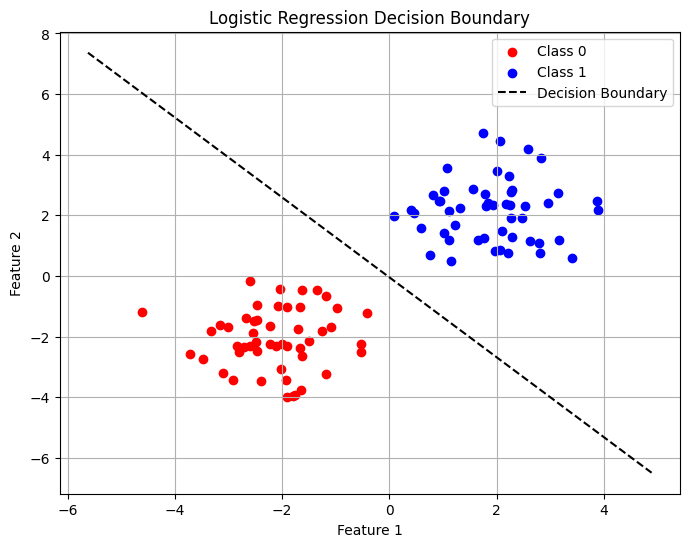

Equation of line: y = -1.3181650714384536 * x + -0.04479655573946814


In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
n_samples = 100

# Class 0
X0 = np.random.randn(n_samples//2, 2) + np.array([-2, -2])
y0 = np.zeros((n_samples//2, ))

# Class 1
X1 = np.random.randn(n_samples//2, 2) + np.array([2, 2])
y1 = np.ones((n_samples//2, ))

# Combine
X = np.vstack([X0, X1])
y = np.hstack([y0, y1])

# Shuffle
shuffle_idx = np.random.permutation(n_samples)
X = X[shuffle_idx]
y = y[shuffle_idx]

# Train Logistic Regression
model = LogisticRegressionGD(learning_rate=0.1, max_iter=10000, tol=1e-6)
model.fit(X, y)

# Plot data
plt.figure(figsize=(8,6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', label='Class 0')
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', label='Class 1')

# Plot decision boundary
# Decision boundary: X @ beta = 0
x1_vals = np.linspace(X[:,0].min()-1, X[:,0].max()+1, 100)
if model.fit_intercept:
    beta0 = model.intercept_
    beta1, beta2 = model.coef_
else:
    beta0 = 0
    beta1, beta2 = model.coef_

x2_vals = -(beta0 + beta1 * x1_vals) / beta2
plt.plot(x1_vals, x2_vals, color='black', linestyle='--', label='Decision Boundary')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Logistic Regression Decision Boundary')
plt.legend()
plt.grid(True)
plt.show()

regular_logistic_slope = -beta1 / beta2
regular_logistic_y_intercept = -beta0 / beta2
print(f"Equation of line: y = {regular_logistic_slope} * x + {regular_logistic_y_intercept}")

Finally, let's see an example using our `LogisticRegressionGD` object to classify some 2D points that are not linearly separable.

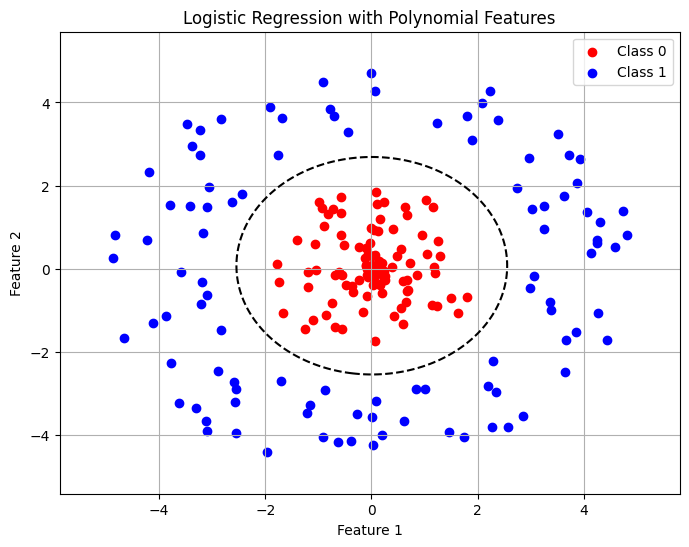

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic nonlinear data
np.random.seed(42)
n_samples = 200

# Class 0: points inside a circle
r0 = np.random.uniform(0.0, 2.0, n_samples//2)
theta0 = np.random.uniform(0, 2*np.pi, n_samples//2)
X0 = np.vstack([r0 * np.cos(theta0), r0 * np.sin(theta0)]).T
y0 = np.zeros((n_samples//2, ))

# Class 1: points outside a circle
r1 = np.random.uniform(3.0, 5.0, n_samples//2)
theta1 = np.random.uniform(0, 2*np.pi, n_samples//2)
X1 = np.vstack([r1 * np.cos(theta1), r1 * np.sin(theta1)]).T
y1 = np.ones((n_samples//2, ))

# Combine
X = np.vstack([X0, X1])
y = np.hstack([y0, y1])

# Shuffle
shuffle_idx = np.random.permutation(n_samples)
X = X[shuffle_idx]
y = y[shuffle_idx]

# Add nonlinear features (Polynomial: x1, x2, x1^2, x2^2)
X_poly = np.hstack([
    X,
    X[:,0:1]**2,
    X[:,1:2]**2
])

# Train Logistic Regression
model = LogisticRegressionGD(learning_rate=0.1, max_iter=10000, tol=1e-6)
model.fit(X_poly, y)

# Plot data
plt.figure(figsize=(8,6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', label='Class 0')
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', label='Class 1')

# Plot nonlinear decision boundary
xx, yy = np.meshgrid(
    np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200),
    np.linspace(X[:,1].min()-1, X[:,1].max()+1, 200)
)

# Prepare polynomial features for the grid
XX = np.c_[xx.ravel(), yy.ravel()]
XX_poly = np.hstack([
    XX,
    XX[:,0:1]**2,
    XX[:,1:2]**2
])

probs = model.predict_proba(XX_poly).reshape(xx.shape)
plt.contour(xx, yy, probs, levels=[0.5], colors='black', linestyles='--')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Logistic Regression with Polynomial Features')
plt.legend()
plt.grid(True)
plt.show()


The same model works even if we add more features, as we see below. The points represent a higher order polinomial, with features such as $x_1, x_2, x_1^2, x_s^2, x_1^3, x_2^3$, etc. The decision boundary for these points will be **even more flexible** (but also risk *overfitting*). It will look like a fancy curvy boundary (wavy, a bit squiggly) fitting the circular pattern of the red points almost perfectly.

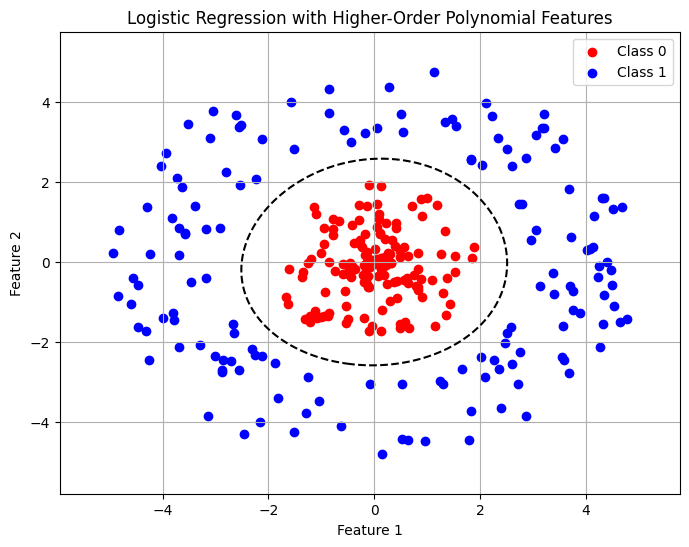

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic nonlinear data
np.random.seed(42)
n_samples = 300

# Class 0: points inside a circle
r0 = np.random.uniform(0.0, 2.0, n_samples//2)
theta0 = np.random.uniform(0, 2*np.pi, n_samples//2)
X0 = np.vstack([r0 * np.cos(theta0), r0 * np.sin(theta0)]).T
y0 = np.zeros((n_samples//2, ))

# Class 1: points outside a circle
r1 = np.random.uniform(3.0, 5.0, n_samples//2)
theta1 = np.random.uniform(0, 2*np.pi, n_samples//2)
X1 = np.vstack([r1 * np.cos(theta1), r1 * np.sin(theta1)]).T
y1 = np.ones((n_samples//2, ))

# Combine
X = np.vstack([X0, X1])
y = np.hstack([y0, y1])

# Shuffle
shuffle_idx = np.random.permutation(n_samples)
X = X[shuffle_idx]
y = y[shuffle_idx]

# Create higher-order polynomial features manually
def create_polynomial_features(X):
    x1 = X[:, 0:1]
    x2 = X[:, 1:2]
    features = np.hstack([
        x1,
        x2,
        x1**2,
        x2**2,
        x1 * x2,
        x1**3,
        x2**3
    ])
    return features

X_poly = create_polynomial_features(X)

# Train Logistic Regression
model = LogisticRegressionGD(learning_rate=0.1, max_iter=10000, tol=1e-6)
model.fit(X_poly, y)

# Plot data
plt.figure(figsize=(8,6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', label='Class 0')
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', label='Class 1')

# Plot decision boundary
xx, yy = np.meshgrid(
    np.linspace(X[:,0].min()-1, X[:,0].max()+1, 300),
    np.linspace(X[:,1].min()-1, X[:,1].max()+1, 300)
)

XX = np.c_[xx.ravel(), yy.ravel()]
XX_poly = create_polynomial_features(XX)

probs = model.predict_proba(XX_poly).reshape(xx.shape)
plt.contour(xx, yy, probs, levels=[0.5], colors='black', linestyles='--')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Logistic Regression with Higher-Order Polynomial Features')
plt.legend()
plt.grid(True)
plt.show()


(Optional) Now that you know how to implement Gradient Descent to solve Linear, Lasso, Ridge, and Logistic Regression, the sky is the limit. You could add a regularization term to Logistic Regression to  simplify the model, as we did in Lasso, or come up with a different cost function and optimize it via gradient descent.

In [64]:
# I decided to use elastic net regularization on logistic regression for this. Also I did a grpah for this below.

class ElasticNetRegularizedLogisticRegressionGD:
    def __init__(self, fit_intercept=True, nulbias=False, learning_rate=0.5, max_iter=1e6, tol=1e-5, l1_penalty=0.1, l2_penalty=1.0):
        if learning_rate <= 0:
            raise ValueError("Learning rate must be positive.")
        if max_iter <= 0:
            raise ValueError("max_iter must be positive.")
        if tol <= 0:
            raise ValueError("tol must be positive.")
        self.fit_intercept = fit_intercept
        self.learning_rate = learning_rate
        self.nulbias = nulbias
        self.max_iter = int(max_iter)
        self.tol = tol
        self.models = []
        self.costs = []
        self.gradients = [] 
        self.coef_ = None
        self.intercept_ = None
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty

    def _add_intercept(self, X):
        return np.hstack([np.ones((X.shape[0], 1)), X])

    def fit(self, X, y):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        y = np.asarray(y).reshape(-1, 1)

        if self.fit_intercept:
            X = self._add_intercept(X)

        n_samples, n_features = X.shape
        theta = np.random.randn(n_features, 1)
        if self.nulbias:
            theta[0] = 0
        # Perform gradient descent
        for _ in range(self.max_iter):
            # Hypothesis/estimate values for y
            y_estimate = 1/(1 + np.exp(-(X @ theta)))
            # Loss - the difference between the estimated and actual values of y
            loss = y_estimate - y
            # Compute gradient
            grad = ((1.0 / n_samples) * X.T.dot(loss))
            l1_grad = self.l1_penalty * np.sign(theta)
            if self.fit_intercept:
                l1_grad[0] = 0
            l2_grad = self.l2_penalty * theta * 2
            if self.fit_intercept:
                l1_grad[0] = 0
                l2_grad[0] = 0
            # Cost function value
            total_grad = grad.reshape(theta.shape) + l1_grad + l2_grad
            if self.fit_intercept:
                total_grad[0] = 0
            l1_term = self.l1_penalty * np.sum(np.abs(theta[1:] if self.fit_intercept else theta))
            l2_term = 0.5 * self.l2_penalty * np.sum(theta[1:]**2 if self.fit_intercept else theta**2)
            eps = 1e-15
            y_estimate_clipped = np.clip(y_estimate, eps, 1 - eps)
            cost = -np.mean(y * np.log(y_estimate_clipped) + (1 - y) * np.log(1 - y_estimate_clipped)) + l1_term + l2_term
            # Keep track of the model, gradient, and cost
            self.models.append(theta)
            self.gradients.append(total_grad)
            self.costs.append(cost)
            # Update theta
            theta_new = theta - self.learning_rate * total_grad
            if self.nulbias:
                theta_new[0] = 0
            # Check for convergence
            if np.sum(abs(theta_new - theta)) < self.tol:
                break
            theta = theta_new

        # we can now set the intercept and coef_ attributes
        if self.fit_intercept:
            self.intercept_ = theta[0, 0]
            self.coef_ = np.ravel(theta[1:, 0])
        else:
            self.intercept_ = 0.0
            self.coef_ = np.ravel(theta[:, 0])

    def compute_cost(self, X, y):
        """Compute the current error/cost."""
        y_estimate = self.predict_proba(X).reshape(-1, 1)
        l1_term = self.l1_penalty * np.sum(np.abs(self.coef_[1:] if self.fit_intercept else self.coef_))
        l2_term = 0.5 * self.l2_penalty * np.sum(self.coef_[1:]**2 if self.fit_intercept else self.coef_**2)
        eps = 1e-15
        y_estimate_clipped = np.clip(y_estimate, eps, 1 - eps)
        y = y.reshape(-1, 1)
        return float(-np.mean(y * np.log(y_estimate_clipped) + (1 - y) * np.log(1 - y_estimate_clipped))) + l1_term + l2_term

    def predict_proba(self, X):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        if self.fit_intercept:
            X = self._add_intercept(X)
            beta = np.concatenate([[self.intercept_], self.coef_])
        else:
            beta = self.coef_
        return (X @ beta).flatten()

    def predict(self, X, threshold=0.5):
        probs = predict_proba(self, X)
        return (probs > threshold).astype(int)

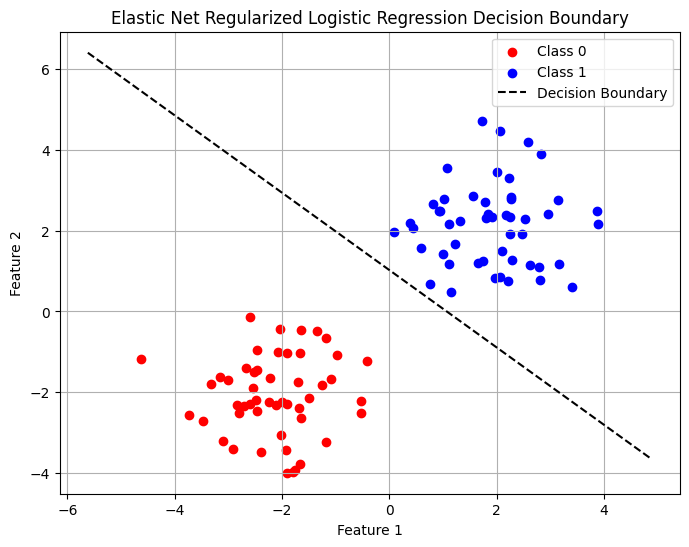

Equation of line: y = -0.9565395557689622 * x + 1.024899077353368 (compared to y = -1.3181650714384536 * x + -0.04479655573946814 for regular logistic regresion)


In [66]:
# Graph for the above method

# Generate synthetic data
np.random.seed(42)
n_samples = 100

# Class 0
X0 = np.random.randn(n_samples//2, 2) + np.array([-2, -2])
y0 = np.zeros((n_samples//2, ))

# Class 1
X1 = np.random.randn(n_samples//2, 2) + np.array([2, 2])
y1 = np.ones((n_samples//2, ))

# Combine
X = np.vstack([X0, X1])
y = np.hstack([y0, y1])

# Shuffle
shuffle_idx = np.random.permutation(n_samples)
X = X[shuffle_idx]
y = y[shuffle_idx]

# Train Logistic Regression
model = ElasticNetRegularizedLogisticRegressionGD(learning_rate=0.1, max_iter=10000, tol=1e-6)
model.fit(X, y)

# Plot data
plt.figure(figsize=(8,6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', label='Class 0')
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', label='Class 1')

# Plot decision boundary
# Decision boundary: X @ beta = 0
x1_vals = np.linspace(X[:,0].min()-1, X[:,0].max()+1, 100)
if model.fit_intercept:
    beta0 = model.intercept_
    beta1, beta2 = model.coef_
else:
    beta0 = 0
    beta1, beta2 = model.coef_

x2_vals = -(beta0 + beta1 * x1_vals) / beta2
plt.plot(x1_vals, x2_vals, color='black', linestyle='--', label='Decision Boundary')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Elastic Net Regularized Logistic Regression Decision Boundary')
plt.legend()
plt.grid(True)
plt.show()

y_intercept = -beta0 / beta2
slope = -beta1 / beta2
print(f"Equation of line: y = {slope} * x + {y_intercept} (compared to y = {regular_logistic_slope} * x + {regular_logistic_y_intercept} for regular logistic regresion)")